В этом нотебуке выполняются шаги из лабораторной работы по обработке изображений:

1. Загрузка и вывод исходного изображения
2. Прямое и обратное косинусное преобразование (DCT / IDCT)
3. Прямое и обратное преобразование Фурье (FFT / IFFT)
4. Сравнение изображений по коэффициенту корреляции
5. Построение спектра яркости
6. Добавление шумов разных типов
7. Фильтрация изображения (средняя, гауссова, медианная, Винера)
8. Анализ коэффициента корреляции от размера маски фильтра

In [1]:
# Импорт библиотек
from __future__ import annotations
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy.fft import fft2, ifft2, fftshift
from scipy.signal import wiener
from scipy.ndimage import uniform_filter, median_filter, gaussian_filter
from skimage import data, img_as_float, util
from skimage.color import rgb2gray
from skimage.util import random_noise
import imageio
import warnings

warnings.filterwarnings('ignore')

## Настройки и вспомогательные функции

In [2]:
IMAGE_PATH = "image.png"
SAVE_RESULTS = False
OUTPUT_DIR = 'results'
GAUSS_VAR = 0.01
SP_AMOUNT = 0.05
SPECKLE_VAR = 0.2
MASK_SIZES = [3, 5, 7, 9, 11]

def ensure_outdir(path: str):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

# def load_image(path: str | None):
#     if path:
#         im = imageio.v2.imread(path)
#         if im.ndim == 3:
#             im = rgb2gray(im)
#         return img_as_float(im)
#     return img_as_float(data.camera())

def load_image(path: str | None):
    if path:
        im = imageio.v2.imread(path)
        if im.ndim == 3:
            if im.shape[2] == 4:
                im = im[:, :, :3]
            im = rgb2gray(im)
        return img_as_float(im)
    return img_as_float(data.camera())

def dct2(a: np.ndarray) -> np.ndarray:
    return fftpack.dct(fftpack.dct(a.T, norm='ortho').T, norm='ortho')

def idct2(a: np.ndarray) -> np.ndarray:
    return fftpack.idct(fftpack.idct(a.T, norm='ortho').T, norm='ortho')

def pearson_corr(a: np.ndarray, b: np.ndarray) -> float:
    a_f, b_f = a.ravel(), b.ravel()
    return np.corrcoef(a_f, b_f)[0, 1]

def radial_profile(data: np.ndarray) -> np.ndarray:
    y, x = np.indices(data.shape)
    center = np.array(data.shape) // 2
    r = np.hypot(x - center[1], y - center[0]).astype(np.int32)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    return tbin / (nr + 1e-12)


## 1. Загрузка и отображение исходного изображения

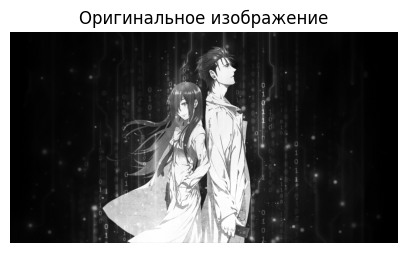

In [3]:
img = load_image(IMAGE_PATH)
plt.figure(figsize=(5,5))
plt.title('Оригинальное изображение')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## 2. Прямое и обратное DCT-преобразование

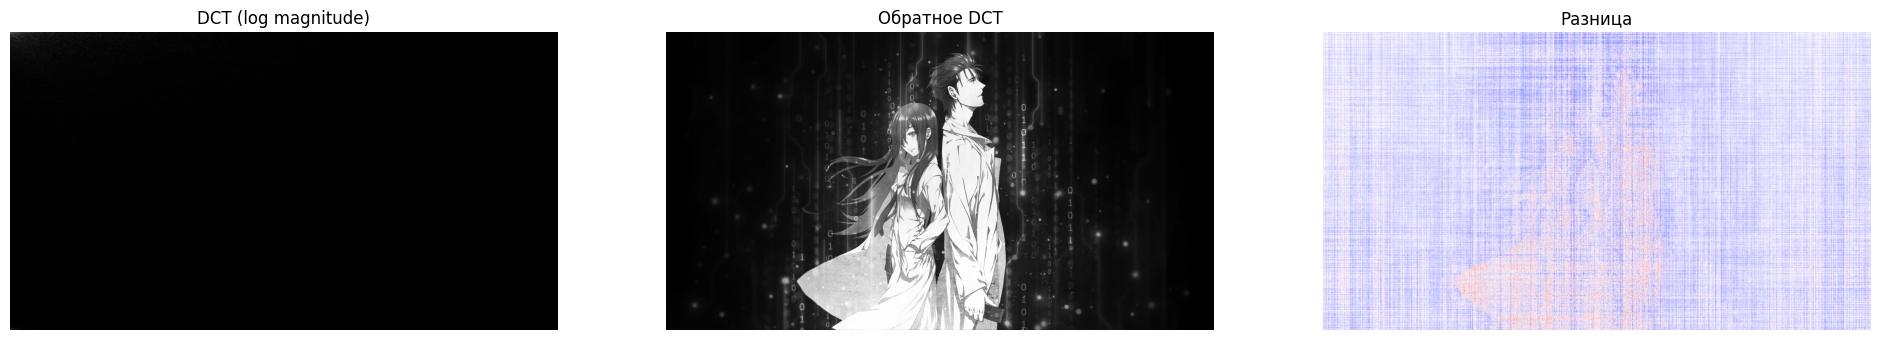

In [4]:
dct_coeffs = dct2(img)
recon_dct = idct2(dct_coeffs)

plt.figure(figsize=(24,8))
plt.subplot(1,3,1); plt.imshow(np.log1p(np.abs(dct_coeffs)), cmap='gray'); plt.title('DCT (log magnitude)'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(np.clip(recon_dct,0,1), cmap='gray'); plt.title('Обратное DCT'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img - recon_dct, cmap='bwr'); plt.title('Разница'); plt.axis('off')
plt.show()

## 3. Прямое и обратное преобразование Фурье

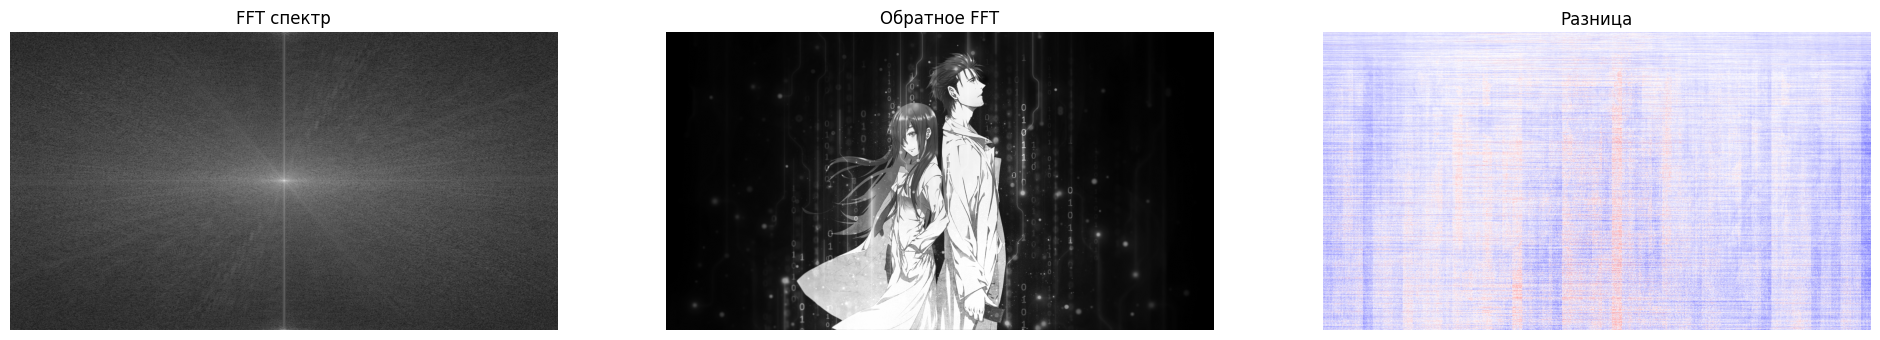

Корреляция DCT: 1.0
Корреляция FFT: 1.0


In [5]:
fft_coeffs = fft2(img)
fft_shift = fftshift(fft_coeffs)
magnitude_spectrum = np.log1p(np.abs(fft_shift))
recon_fft = np.real(ifft2(fft_coeffs))

plt.figure(figsize=(24,8))
plt.subplot(1,3,1); plt.imshow(magnitude_spectrum, cmap='gray'); plt.title('FFT спектр'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(np.clip(recon_fft,0,1), cmap='gray'); plt.title('Обратное FFT'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img - recon_fft, cmap='bwr'); plt.title('Разница'); plt.axis('off')
plt.show()

print('Корреляция DCT:', pearson_corr(img, recon_dct))
print('Корреляция FFT:', pearson_corr(img, recon_fft))

## 4. Спектр яркости

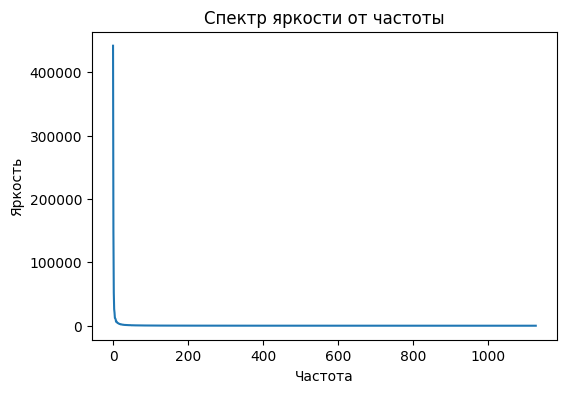

In [6]:
radial = radial_profile(np.abs(fft_shift))
plt.figure(figsize=(6,4))
plt.title('Спектр яркости от частоты')
plt.plot(radial)
plt.xlabel('Частота')
plt.ylabel('Яркость')
plt.show()

## 5. Добавление шумов

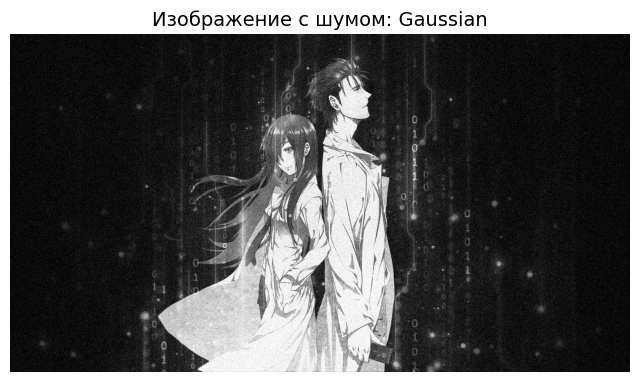

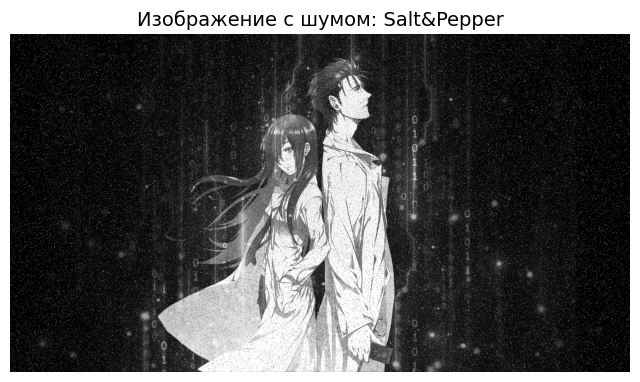

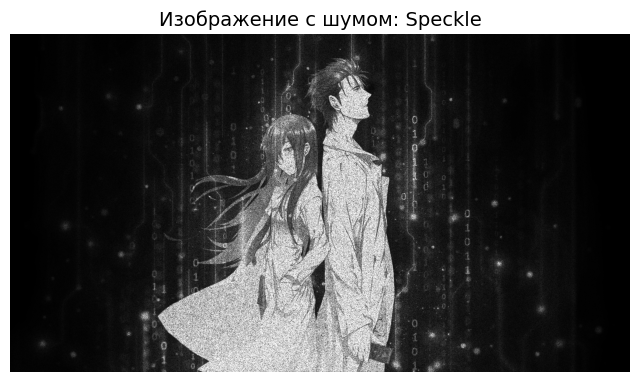

In [ ]:
noises = {
    'Gaussian': random_noise(img, mode='gaussian', var=GAUSS_VAR),
    'Salt&Pepper': random_noise(img, mode='s&p', amount=SP_AMOUNT),
    'Speckle': random_noise(img, mode='speckle', var=SPECKLE_VAR)
}
fig, axs = plt.subplots(1,3, figsize=(24, 8))
for ax, (name, nimg) in zip(axs, noises.items()):
    ax.imshow(nimg, cmap='gray'); ax.set_title(name); ax.axis('off')
plt.show()

for name, nimg in noises.items():
    plt.figure(figsize=(8, 6))
    plt.imshow(nimg, cmap='gray')
    plt.title(f'Изображение с шумом: {name}', fontsize=14)
    plt.axis('off')
    plt.show()

## 6. Фильтрация и анализ корреляции

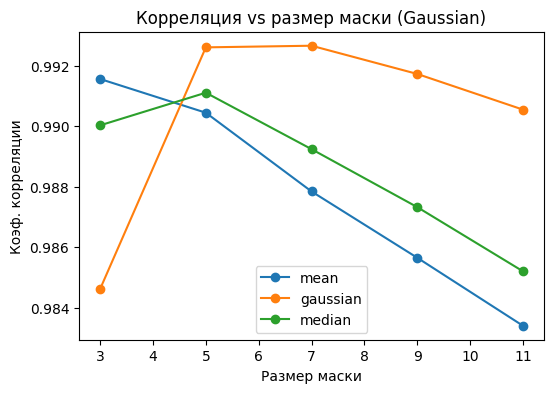

Wiener корреляция (Gaussian): 0.9917


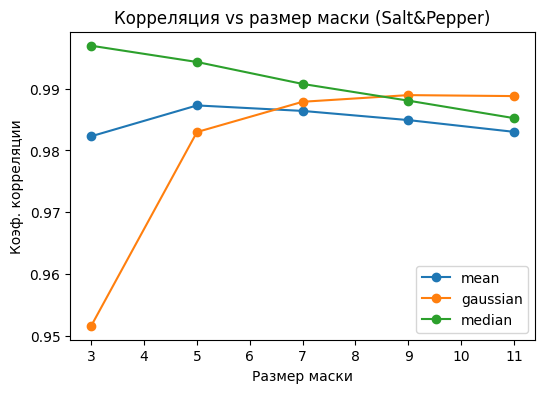

Wiener корреляция (Salt&Pepper): 0.9262


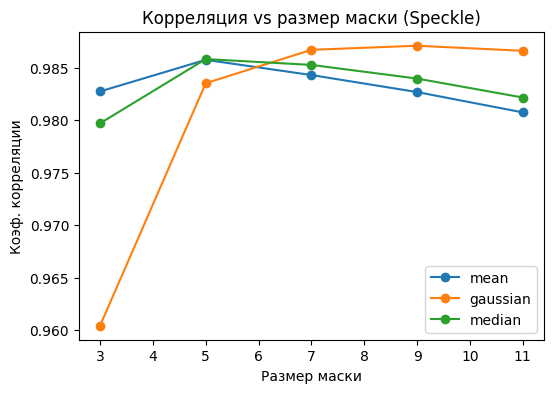

Wiener корреляция (Speckle): 0.9434


In [8]:
def apply_filters_for_sizes(noisy_img, sizes):
    results = {'mean': {}, 'gaussian': {}, 'median': {}}
    for s in sizes:
        results['mean'][s] = uniform_filter(noisy_img, size=s)
        results['gaussian'][s] = gaussian_filter(noisy_img, sigma=max(0.3, s/6.0))
        results['median'][s] = median_filter(noisy_img, size=s)
    return results

def evaluate_filters(original, filters_dict, sizes):
    corr_vs_size = {name: [] for name in filters_dict.keys()}
    for name, d in filters_dict.items():
        for s in sizes:
            corr_vs_size[name].append(pearson_corr(original, np.clip(d[s], 0, 1)))
    return corr_vs_size

for noise_name, noisy in noises.items():
    filters = apply_filters_for_sizes(noisy, MASK_SIZES)
    corr_data = evaluate_filters(img, filters, MASK_SIZES)
    plt.figure(figsize=(6,4))
    for k,v in corr_data.items():
        plt.plot(MASK_SIZES, v, marker='o', label=k)
    plt.title(f'Корреляция vs размер маски ({noise_name})')
    plt.xlabel('Размер маски')
    plt.ylabel('Коэф. корреляции')
    plt.legend()
    plt.show()

    wiener_corr = pearson_corr(img, np.clip(wiener(noisy), 0, 1))
    print(f'Wiener корреляция ({noise_name}): {wiener_corr:.4f}')